In [7]:
import pandas as pandas
import numpy as numpy
import os
import win32com.client
import ntpath
import fnmatch
import glob
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import FreqDist
import re
import matplotlib.pyplot as matplot
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing

In [8]:
def plot_confusion_matrix(Y_test,Y_predict, target_names,title='Confusion matrix',cmap=None,normalize=True):
    cm = metrics.confusion_matrix(Y_test, Y_predict)
    accuracy = numpy.trace(cm) / float(numpy.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = matplot.get_cmap('Blues')

    matplot.figure(figsize=(8, 6))
    matplot.imshow(cm, interpolation='nearest', cmap=cmap)
    matplot.title(title)
    matplot.colorbar()

    if target_names is not None:
        tick_marks = numpy.arange(len(target_names))
        matplot.xticks(tick_marks, target_names, rotation=45)
        matplot.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            matplot.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            matplot.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    matplot.tight_layout()
    matplot.ylabel('True label')
    matplot.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    matplot.show()
    print(metrics.classification_report(Y_test, Y_predict))

In [9]:
def create_email_dataset(x):
    h = len(glob.glob("*.msg"))

    SenderName = []
    SenderEmailAddress = []
    To = []
    CC = []
    BCC = []
    Body = []
    Subject = []
    attachments = []



    for i in range(0,h):
        #print(i)
        GFile = str(fnmatch.filter(os.listdir(), '*.msg')[i])
        path = (glob.glob(x+str(GFile)))[0]
        outlook = win32com.client.Dispatch("Outlook.Application").GetNamespace("MAPI")
        msg = outlook.OpenSharedItem(path) 

        SenderName.append(msg.SenderName)    
        SenderEmailAddress.append(msg.SenderEmailAddress)    
        To.append(msg.To)    
        CC.append(msg.CC)    
        BCC.append(msg.BCC)    
        Subject.append(msg.Subject)    
        Body.append(msg.Body)    
        count_attachments = msg.Attachments.Count
        if count_attachments > 0:
            for item in range(count_attachments):
                attachments.append(msg.Attachments.Item(item + 1).Filename)

        del outlook, msg
    return SenderEmailAddress, SenderName, To, CC, BCC, Subject, Body, attachments

In [10]:
os.chdir("C:\\Siddhartha\\Confidential Documents\\Data Science\\Email\\cms emails\\")
Dir = "C:\\Siddhartha\\Confidential Documents\\Data Science\\Email\\cms emails\\"

In [11]:
SenderEmailAddress, SenderName, To, CC, BCC, Subject, Body, attachments = create_email_dataset(Dir)

In [12]:
Source_cms = pandas.DataFrame({"Department" : "Cash","SenderName" : SenderName,"SenderEmailAddress" : SenderEmailAddress, "To" : To, "CC" : CC,"BCC" : BCC,
                          "Subject" : Subject, "Body" : Body}, 
                          columns = ["Department","SenderName","SenderEmailAddress","To","CC","BCC","Subject","Body"])

In [13]:
os.chdir("C:\\Siddhartha\\Confidential Documents\\Data Science\\Email\\Trade emails\\")
Dir1 = "C:\\Siddhartha\\Confidential Documents\\Data Science\\Email\\Trade emails\\"

In [14]:
SenderEmailAddress1, SenderName1, To1, CC1, BCC1, Subject1, Body1, attachments1 = create_email_dataset(Dir1)

In [15]:
Source_Trade = pandas.DataFrame({"Department" : "Trade","SenderName" : SenderName1,"SenderEmailAddress" : SenderEmailAddress1, "To" : To1, "CC" : CC1,"BCC" : BCC1,
                          "Subject" : Subject1, "Body" : Body1}, 
                          columns = ["Department","SenderName","SenderEmailAddress","To","CC","BCC","Subject","Body"])

In [16]:
Source_cms.head()

,Department,SenderName,SenderEmailAddress,To,CC,BCC,Subject,Body
0,Cash,NSRD-Bills Payment,NSRD-Bills-Payment@bdo.com.ph,"CMS-FI; AS&ICS, PHCMS",CMS PH - AS&ICS; duque.christinemarie@bdo.com....,,[External] 402 092818 Re: SCB Fao AdiXXX Inquiry,"\r\nHi, status please. Thanks\r\n\r\nRegards,\..."
1,Cash,Special_Project,smsi.specialproject@scnerve.com,"Mendoza, Rodil; AS&ICS, PHCMS",Rolando P. Bagano,,[External] ABBOTT - Billing for September 2018,"Ma’am Ria,\r\n\r\n \r\n\r\n \r\n\r\nAttached i..."
2,Cash,Special_Project,smsi.specialproject@scnerve.com,"AS&ICS, PHCMS","Mendoza, Rodil; Rolando P. Bagano; Precy B. Ga...",,"[External] ABBOTT - Maturity October 02, 2018","Sir,\r\n\r\n \r\n\r\nABBOTT - Maturity for Oct..."
3,Cash,Special_Project,smsi.specialproject@scnerve.com,"AS&ICS, PHCMS","Mendoza, Rodil; Rolando P. Bagano; Precy B. Ga...",,"[External] ABBOTT - Maturity October 05, 2018","Sir,\r\n\r\n \r\n\r\nABBOTT - Maturity for Oct..."
4,Cash,Special_Project,smsi.specialproject@scnerve.com,"AS&ICS, PHCMS","Mendoza, Rodil; Rolando P. Bagano; Precy B. Ga...",,"[External] ABBOTT - Maturity September 29, & 3...","Sir,\r\n\r\n \r\n\r\nABBOTT - Maturity for Sep..."


In [17]:
Source = Source_cms.append(Source_Trade)
Source = Source.reset_index()
del Source["index"]

In [18]:
Source.head()

,Department,SenderName,SenderEmailAddress,To,CC,BCC,Subject,Body
0,Cash,NSRD-Bills Payment,NSRD-Bills-Payment@bdo.com.ph,"CMS-FI; AS&ICS, PHCMS",CMS PH - AS&ICS; duque.christinemarie@bdo.com....,,[External] 402 092818 Re: SCB Fao AdiXXX Inquiry,"\r\nHi, status please. Thanks\r\n\r\nRegards,\..."
1,Cash,Special_Project,smsi.specialproject@scnerve.com,"Mendoza, Rodil; AS&ICS, PHCMS",Rolando P. Bagano,,[External] ABBOTT - Billing for September 2018,"Ma’am Ria,\r\n\r\n \r\n\r\n \r\n\r\nAttached i..."
2,Cash,Special_Project,smsi.specialproject@scnerve.com,"AS&ICS, PHCMS","Mendoza, Rodil; Rolando P. Bagano; Precy B. Ga...",,"[External] ABBOTT - Maturity October 02, 2018","Sir,\r\n\r\n \r\n\r\nABBOTT - Maturity for Oct..."
3,Cash,Special_Project,smsi.specialproject@scnerve.com,"AS&ICS, PHCMS","Mendoza, Rodil; Rolando P. Bagano; Precy B. Ga...",,"[External] ABBOTT - Maturity October 05, 2018","Sir,\r\n\r\n \r\n\r\nABBOTT - Maturity for Oct..."
4,Cash,Special_Project,smsi.specialproject@scnerve.com,"AS&ICS, PHCMS","Mendoza, Rodil; Rolando P. Bagano; Precy B. Ga...",,"[External] ABBOTT - Maturity September 29, & 3...","Sir,\r\n\r\n \r\n\r\nABBOTT - Maturity for Sep..."


In [19]:
w = []
e = []
for i in range(0,len(Source)):
    u = ((Source["To"].str.split(";"))[i])
    w.append(u)
le = preprocessing.LabelEncoder()
R1 = le.fit_transform(w)
To_split = pandas.DataFrame(R1,columns = ["To_split"])

R = []
S = []
for i in range(0,len(Source)):
    a = ((Source["CC"].str.split(";"))[i])
    R.append(a)
le = preprocessing.LabelEncoder()
R2 = le.fit_transform(R)
CC_split = pandas.DataFrame(R2,columns = ["CC_Split"])

In [20]:
le = preprocessing.LabelEncoder()
R3 = le.fit_transform(Source["SenderName"])
SenderName_encoded = pandas.DataFrame(R3,columns = ["SenderName_encoded"])

In [21]:
SenderName_encoded

,SenderName_encoded
0,48
1,67
2,67
3,67
4,67
5,67
6,67
7,17
8,17
9,17


In [22]:
os.chdir("C:\\Siddhartha\\Confidential Documents\\Data Science\\Email\\")

In [23]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", " ", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = pandas.read_csv("stop word list.csv")
stop_words1 = stop_words['i'].tolist()
def remove_stop_words(text):
    a = [word for word in text if word not in stop_words]
    return a


stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    text = [stemmer.stem(word) for word in text]
    text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    
    return text

def apply_all(text):
    a = initial_clean(text)
    b = remove_stop_words(a)
    c = stem_words(b)
    return c

In [24]:
data = Source['Subject'].apply(apply_all)

In [25]:
data

0                [extern, re, scb, fao, adixxx, inquiri]
1                   [extern, abbott, bill, for, septemb]
2                         [extern, abbott, matur, octob]
3                         [extern, abbott, matur, octob]
4                [extern, abbott, matur, septemb, octob]
5                      [extern, abbott, outstand, amend]
6                             [extern, abbott, outstand]
7      [extern, abbott, laboratori, octob, collect, r...
8      [extern, abbott, laboratori, septemb, collect,...
9      [extern, abbott, laboratori, septemb, collect,...
10     [extern, abbott, laboratori, septemb, collect,...
11     [extern, abbott, laboratori, septemb, collect,...
12     [extern, abbott, laboratori, septemb, collect,...
13                [extern, addit, adida, scb, dep, slip]
14                [extern, addit, adida, scb, dep, slip]
15                   [extern, addit, collect, it, octob]
16                 [extern, addit, collect, it, septemb]
17     [extern, adida, philippi

In [26]:
data = pandas.DataFrame(data)

In [27]:
Data = []
for i in range(0,len(Source)):
    ai = ' '.join(data["Subject"][i])
    Data.append(ai)

In [28]:
Data

['extern re scb fao adixxx inquiri',
 'extern abbott bill for septemb',
 'extern abbott matur octob',
 'extern abbott matur octob',
 'extern abbott matur septemb octob',
 'extern abbott outstand amend',
 'extern abbott outstand',
 'extern abbott laboratori octob collect report',
 'extern abbott laboratori septemb collect report',
 'extern abbott laboratori septemb collect report',
 'extern abbott laboratori septemb collect report',
 'extern abbott laboratori septemb collect report',
 'extern abbott laboratori septemb collect report',
 'extern addit adida scb dep slip',
 'extern addit adida scb dep slip',
 'extern addit collect it octob',
 'extern addit collect it septemb',
 'extern adida philippin inc octob collect report',
 'extern adida philippin inc septemb collect report',
 'extern adida philippin inc septemb collect report',
 'extern adida philippin inc septemb collect report',
 'extern advisori bancnet ist po system transfer to primari site cancel',
 'extern advisori bancnet ist 

In [29]:
tfidf = TfidfVectorizer(sublinear_tf=True,  norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=stop_words1)
features = tfidf.fit_transform(pandas.DataFrame(Data)[0]).toarray()
#labels = df.category_id
#features.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [30]:
Subject_Features = pandas.DataFrame(features, columns=tfidf.get_feature_names())

In [31]:
Subject_Features.head()

,abbott,abbott bill,abbott deposit,abbott laboratori,abbott matur,abbott outstand,abov,accept,accept document,account,...,visa,visa fee,wed,wed sgt,west,west african,wilmar,wonderpack,wonderpack industri,zar
0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.393662,0.588459,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.414993,0.000000,0.0,0.0,0.558528,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.414993,0.000000,0.0,0.0,0.558528,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.339884,0.000000,0.0,0.0,0.457440,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
#Source = Source.join(Subject_Features)

In [33]:
Source.shape

(771, 8)

In [34]:
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(Subject_Features)
principalDf = pandas.DataFrame(data = principalComponents, columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10'])

In [35]:
principalDf.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-0.087294,-0.113175,-0.021482,0.018321,0.006169,0.041312,0.010764,0.031196,-0.067751,-0.026838
1,-0.094409,-0.128168,-0.049143,-0.068230,-0.001490,-0.016103,0.000571,0.017676,-0.022882,-0.017423
2,-0.098687,-0.136842,-0.060874,-0.077652,-0.005216,-0.014383,0.010558,0.119545,-0.021633,-0.069922
3,-0.098687,-0.136842,-0.060874,-0.077652,-0.005216,-0.014383,0.010558,0.119545,-0.021633,-0.069922
4,-0.099862,-0.139500,-0.068711,-0.112690,-0.007881,-0.042427,0.001532,0.084283,0.005919,-0.041164


In [36]:
principalDf = principalDf.join([To_split,CC_split,SenderName_encoded])

In [37]:
principalDf.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'To_split', 'CC_Split', 'SenderName_encoded'],
      dtype='object')

In [38]:
Y = pandas.DataFrame(Source["Department"])
X = principalDf
X_train, X_Val, Y_train, Y_Val = train_test_split(X, Y, test_size=.1, random_state=100)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=.3, random_state=100)

In [39]:
X_train

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,To_split,CC_Split,SenderName_encoded
614,-0.393077,0.833211,0.011892,-0.020235,-0.031841,0.002604,-0.000803,-0.003055,0.006840,0.002812,183,104,71
257,-0.102953,-0.147034,-0.081094,-0.108879,-0.019896,-0.017862,0.154703,0.037188,0.098107,-0.014313,9,0,59
510,0.862740,0.183945,0.006604,-0.005694,-0.004922,-0.005891,-0.001678,-0.004764,0.008459,0.003531,199,104,71
238,-0.096026,-0.130601,-0.028944,0.038021,0.012700,0.102675,0.034455,0.136398,-0.383761,0.650551,9,0,9
199,-0.113652,-0.169742,-0.146003,-0.460975,-0.001122,-0.257674,-0.062362,-0.235347,0.113352,0.079494,35,86,17
309,-0.109570,-0.160299,-0.105334,0.549886,-0.541463,-0.373508,-0.092698,-0.298877,0.053129,0.033957,9,0,6
470,0.098292,-0.055810,-0.018086,0.019813,0.014874,0.031510,0.009272,0.028321,-0.060700,-0.031778,206,104,71
742,-0.118193,-0.181661,0.941781,-0.051217,-0.015980,-0.079037,-0.016003,-0.037122,0.072457,0.011956,138,0,68
268,-0.087827,-0.114546,-0.026157,0.057801,-0.034151,0.008788,0.000546,-0.019396,-0.072035,-0.023764,30,94,55
145,-0.111494,-0.164179,-0.118216,-0.271745,-0.015622,-0.136610,-0.004055,0.071187,0.082291,-0.031502,1,91,5


In [40]:
dt_model = DecisionTreeClassifier(criterion = 'entropy' )
dt_model.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [41]:
train_char_label = ["Cash","Trade"]

In [42]:
from IPython.display import Image  
#import pydotplus as pydot
from sklearn import tree
from os import system

Model_Tree_File = open('email.dot','w')
dot_data = tree.export_graphviz(dt_model, out_file=Model_Tree_File, feature_names = list(X_train), class_names = list(train_char_label))

Model_Tree_File.close()


# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print (pandas.DataFrame(dt_model.feature_importances_, columns = ["Imp"], index = X_train.columns))

                         Imp
PC1                 0.008547
PC2                 0.000000
PC3                 0.017948
PC4                 0.128052
PC5                 0.000000
PC6                 0.000000
PC7                 0.162233
PC8                 0.000000
PC9                 0.000000
PC10                0.000000
To_split            0.493509
CC_Split            0.162881
SenderName_encoded  0.026830


In [43]:
Y_predict = dt_model.predict(X_test)

1.0
0.9807692307692307


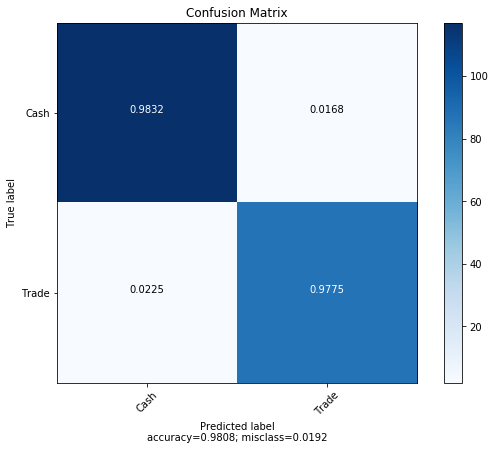

             precision    recall  f1-score   support

       Cash       0.98      0.98      0.98       119
      Trade       0.98      0.98      0.98        89

avg / total       0.98      0.98      0.98       208



In [44]:
print(dt_model.score(X_train , Y_train))
print(dt_model.score(X_test, Y_test))
plot_confusion_matrix(Y_test, Y_predict, train_char_label,title = "Confusion Matrix", cmap = None, normalize= True)

1.0
0.9487179487179487


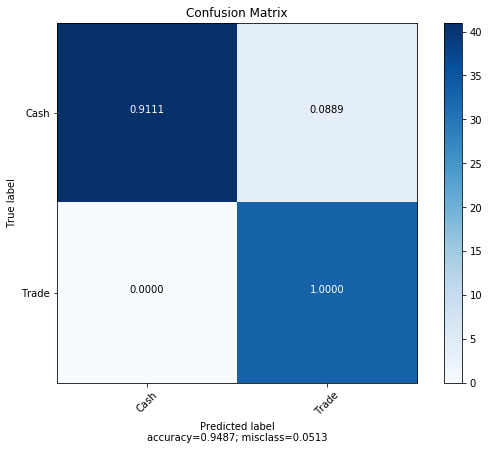

             precision    recall  f1-score   support

       Cash       1.00      0.91      0.95        45
      Trade       0.89      1.00      0.94        33

avg / total       0.95      0.95      0.95        78



In [45]:
Y_Val_Predict = dt_model.predict(X_Val)
print(dt_model.score(X_train , Y_train))
print(dt_model.score(X_Val, Y_Val))
plot_confusion_matrix(Y_Val, Y_Val_Predict, train_char_label,title = "Confusion Matrix", cmap = None, normalize= True)

# Regularizing

In [51]:
dt_model_Reg = DecisionTreeClassifier(criterion = 'entropy', max_depth=8 )
dt_model_Reg.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [52]:
from IPython.display import Image  
#import pydotplus as pydot
from sklearn import tree
from os import system

Model_Tree_File = open('email_reg.dot','w')
dot_data = tree.export_graphviz(dt_model_Reg, out_file=Model_Tree_File, feature_names = list(X_train), class_names = list(train_char_label))

Model_Tree_File.close()


# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print (pandas.DataFrame(dt_model_Reg.feature_importances_, columns = ["Imp"], index = X_train.columns))

                         Imp
PC1                 0.000000
PC2                 0.000000
PC3                 0.008547
PC4                 0.118705
PC5                 0.000000
PC6                 0.000000
PC7                 0.162233
PC8                 0.000000
PC9                 0.000000
PC10                0.009347
To_split            0.511457
CC_Split            0.162881
SenderName_encoded  0.026830


In [53]:
Y_predict_Reg = dt_model_Reg.predict(X_test)

1.0
0.9855769230769231


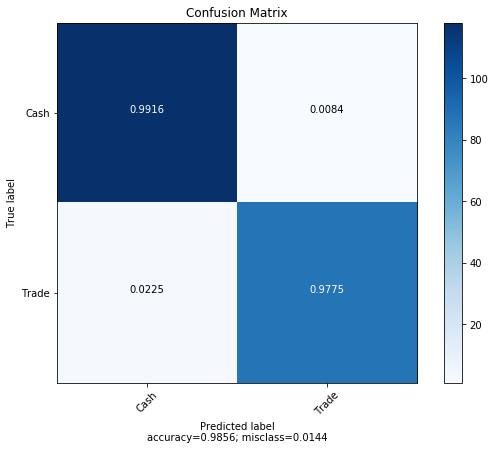

             precision    recall  f1-score   support

       Cash       0.98      0.99      0.99       119
      Trade       0.99      0.98      0.98        89

avg / total       0.99      0.99      0.99       208



In [54]:
print(dt_model_Reg.score(X_train , Y_train))
print(dt_model_Reg.score(X_test, Y_test))
plot_confusion_matrix(Y_test, Y_predict_Reg, train_char_label,title = "Confusion Matrix", cmap = None, normalize= True)

1.0
0.9615384615384616


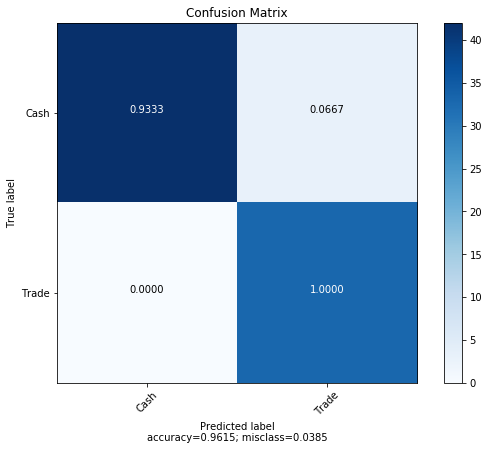

             precision    recall  f1-score   support

       Cash       1.00      0.93      0.97        45
      Trade       0.92      1.00      0.96        33

avg / total       0.96      0.96      0.96        78



In [55]:
Y_Val_Predict_Reg = dt_model_Reg.predict(X_Val)
print(dt_model_Reg.score(X_train , Y_train))
print(dt_model_Reg.score(X_Val, Y_Val))
plot_confusion_matrix(Y_Val, Y_Val_Predict_Reg, train_char_label,title = "Confusion Matrix", cmap = None, normalize= True)

In [56]:
import pickle
with open('DT.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(dt_model_Reg, f, pickle.HIGHEST_PROTOCOL)

In [57]:
with open('DT.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    load_dt_model_Reg = pickle.load(f)

In [58]:
load_dt_model_Reg.predict(X_Val)

array(['Cash', 'Cash', 'Trade', 'Cash', 'Trade', 'Trade', 'Trade', 'Cash',
       'Cash', 'Cash', 'Trade', 'Trade', 'Cash', 'Cash', 'Cash', 'Trade',
       'Cash', 'Trade', 'Cash', 'Trade', 'Cash', 'Cash', 'Cash', 'Cash',
       'Trade', 'Cash', 'Cash', 'Trade', 'Trade', 'Cash', 'Cash', 'Cash',
       'Cash', 'Cash', 'Trade', 'Trade', 'Trade', 'Cash', 'Cash', 'Trade',
       'Trade', 'Trade', 'Trade', 'Trade', 'Trade', 'Trade', 'Cash',
       'Trade', 'Trade', 'Cash', 'Cash', 'Cash', 'Cash', 'Cash', 'Cash',
       'Trade', 'Cash', 'Cash', 'Cash', 'Cash', 'Trade', 'Cash', 'Trade',
       'Trade', 'Trade', 'Trade', 'Cash', 'Trade', 'Trade', 'Trade',
       'Trade', 'Cash', 'Trade', 'Cash', 'Cash', 'Trade', 'Cash', 'Cash'],
      dtype=object)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


1.0
0.9855769230769231


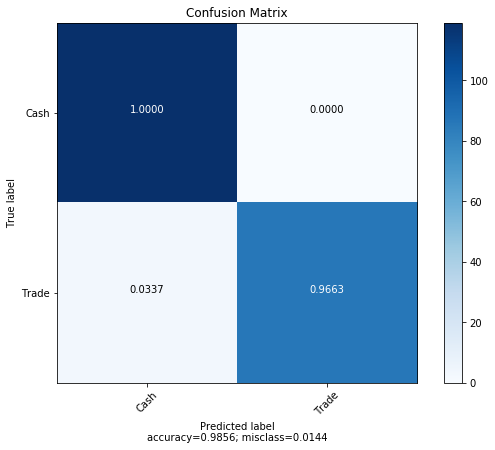

             precision    recall  f1-score   support

       Cash       0.98      1.00      0.99       119
      Trade       1.00      0.97      0.98        89

avg / total       0.99      0.99      0.99       208



In [59]:
rfcl = RandomForestClassifier(n_estimators = 50)
rfcl = rfcl.fit(X_train, Y_train)
Y_predict_rfcl = rfcl.predict(X_test)
print(rfcl.score(X_train , Y_train))
print(rfcl.score(X_test, Y_test))
plot_confusion_matrix(Y_test, Y_predict_rfcl, train_char_label,title = "Confusion Matrix", cmap = None, normalize= True)

1.0
0.9487179487179487


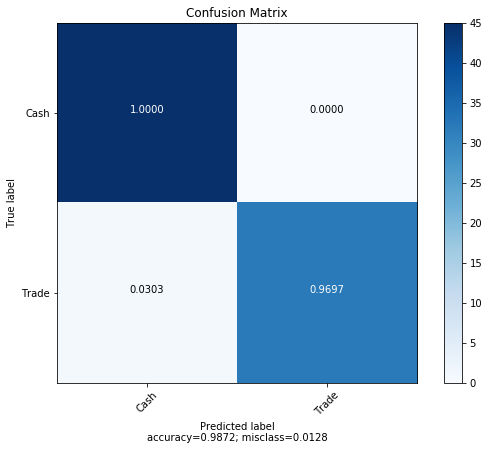

             precision    recall  f1-score   support

       Cash       0.98      1.00      0.99        45
      Trade       1.00      0.97      0.98        33

avg / total       0.99      0.99      0.99        78



In [60]:
Y_Val_Predict_rfcl =rfcl.predict(X_Val)
print(dt_model_Reg.score(X_train , Y_train))
print(dt_model_Reg.score(X_Val, Y_Val_Predict_rfcl))
plot_confusion_matrix(Y_Val, Y_Val_Predict_rfcl, train_char_label,title = "Confusion Matrix", cmap = None, normalize= True)